In [1004]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [1005]:
data_dirpath = Path('../..') / 'data'
output_dirpath = data_dirpath / 'output/imputation'
openml_dirpath = data_dirpath / 'openml'
fig_dirpath = output_dirpath / 'fig'
fig_dirpath.mkdir(parents=True, exist_ok=True)

methods = ['meanmode', 'knn', 'rf']
llm_models = [
  'meta-llama/Llama-2-13b-chat-hf', 
  'meta-llama/Llama-2-70b-chat-hf', 
  'mistralai/Mistral-7B-Instruct-v0.2', 
  'mistralai/Mixtral-8x7B-Instruct-v0.1'
]
[methods.append(f'llm/{model}') for model in llm_models]

[None, None, None, None]

In [1006]:
def fetch_openml_description_length(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dataset_length_dict = {}
    for openml_id in dataset_list['did']:
        dataset_description_filepath = openml_dirpath / f'{openml_id}/description.txt'
        with open(dataset_description_filepath) as f:
            dataset_description = f.read()
            dataset_description_length = len(dataset_description)
            dataset_length_dict[openml_id] = dataset_description_length
    return dataset_length_dict

dataset_length_dict = fetch_openml_description_length(openml_dirpath)

In [1007]:
def fetch_openml_num_features(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dataset_num_features_dict = { openml_id: n_features-1 for openml_id, n_features in zip(dataset_list['did'], dataset_list['NumberOfFeatures']) }
    return dataset_num_features_dict

dataset_num_features_dict = fetch_openml_num_features(openml_dirpath)

In [1008]:
def fetch_openml_category(openml_dirpath: Path):
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    # update natural language processing -> NLP
    dataset_list['category (manually)'] = dataset_list['category (manually)'].replace('natural language processing', 'NLP')
    dataset_category_dict = { openml_id: category for openml_id, category in zip(dataset_list['did'], dataset_list['category (manually)']) }
    return dataset_category_dict

dataset_category_dict = fetch_openml_category(openml_dirpath)

In [1009]:
rmse_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'rmse'])
macro_f1_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'macro_f1'])
downstream_df = pd.DataFrame(columns=['method', 'openml_id', 'openml_desc_len', 'category', 'n_features', 'accuracy', 'macro_f1'])
corrected_methods = {
    'meanmode': 'Mean/Mode', 
    'knn': '$k$-NN', 
    'rf': 'Random Forest', 
    'llm/meta-llama/Llama-2-13b-chat-hf': 'LLaMA 2 13B Chat', 
    'llm/meta-llama/Llama-2-70b-chat-hf': 'LLaMA 2 70B Chat', 
    'llm/mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B Instruct',
    'llm/mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B Instruct'
}

for method in methods:
    method_output_dirpath = output_dirpath / method
    method_imputation_results_filepath = method_output_dirpath / f'imputation_complete.csv'
    method_imputation_results = pd.read_csv(method_imputation_results_filepath, header=0)
    method_imputation_results = method_imputation_results.drop(['timestamp'], axis=1)
    method_imputation_results['method_id'] = list(corrected_methods.keys()).index(method)
    method_imputation_results['method'] = corrected_methods[method]
    method_imputation_results['openml_desc_len'] = method_imputation_results['openml_id'].map(dataset_length_dict)
    method_imputation_results['category'] = method_imputation_results['openml_id'].map(dataset_category_dict)
    method_imputation_results['n_features'] = method_imputation_results['openml_id'].map(dataset_num_features_dict)

    rmse_df = pd.concat([rmse_df, method_imputation_results.drop(['macro_f1', 'missing_column_name'], axis=1).dropna()])
    macro_f1_df = pd.concat([macro_f1_df, method_imputation_results.drop(['rmse', 'missing_column_name'], axis=1).dropna()])

    method_downstream_results_filepath = method_output_dirpath / f'downstream_complete.csv'
    method_downstream_results = pd.read_csv(method_downstream_results_filepath, header=0)
    method_downstream_results = method_downstream_results.drop(['timestamp'], axis=1)
    method_downstream_results['method_id'] = list(corrected_methods.keys()).index(method)
    method_downstream_results['method'] = corrected_methods[method]
    method_downstream_results['openml_desc_len'] = method_downstream_results['openml_id'].map(dataset_length_dict)
    method_downstream_results['category'] = method_downstream_results['openml_id'].map(dataset_category_dict)
    method_downstream_results['n_features'] = method_downstream_results['openml_id'].map(dataset_num_features_dict)
    
    downstream_df = pd.concat([downstream_df, method_downstream_results.dropna()])

rmse_df = rmse_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness', 'missing_column_type']).mean().reset_index()
rmse_df = rmse_df.sort_values('method_id').reset_index(drop=True)

macro_f1_df = macro_f1_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness', 'missing_column_type']).mean().reset_index()
macro_f1_df = macro_f1_df.sort_values('method_id').reset_index(drop=True)

downstream_df = downstream_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness']).mean().reset_index()
downstream_df = downstream_df.sort_values('method_id').reset_index(drop=True)

/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_62775/2383711213.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, method_imputation_results.drop(['macro_f1', 'missing_column_name'], axis=1).dropna()])
/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_62775/2383711213.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  macro_f1_df = pd.concat([macro_f1_df, method_imputation_results.drop(['rmse', 'missing_column_name'], axis=1).dropna()])
/var

In [1010]:
downstream_baseline_df_filepath = output_dirpath / 'baseline/train_incomplete/downstream_complete.csv'
downstream_baseline_df = pd.read_csv(downstream_baseline_df_filepath, header=0)
downstream_baseline_df = downstream_baseline_df.drop(['timestamp'], axis=1)
downstream_baseline_df['method'] = 'Baseline'
downstream_baseline_df['method_id'] = -1
downstream_baseline_df['openml_desc_len'] = downstream_baseline_df['openml_id'].map(dataset_length_dict)
downstream_baseline_df['category'] = downstream_baseline_df['openml_id'].map(dataset_category_dict)
downstream_baseline_df['n_features'] = downstream_baseline_df['openml_id'].map(dataset_num_features_dict)
downstream_baseline_df = downstream_baseline_df.groupby(['method', 'method_id', 'openml_id', 'openml_desc_len', 'category', 'missingness']).mean().reset_index()
downstream_baseline_df = downstream_baseline_df.sort_values('method_id').reset_index(drop=True)

In [1011]:
downstream_baseline_df

,method,method_id,openml_id,openml_desc_len,category,missingness,accuracy,macro_f1,n_features
0,Baseline,-1,3,3178,board game,MAR,0.984375,0.984320,36.0
1,Baseline,-1,1475,838,computer science,MAR,0.608660,0.514923,51.0
2,Baseline,-1,1478,3817,computer vision,MAR,0.975728,0.975478,561.0
3,Baseline,-1,1480,1631,medicine,MAR,0.735043,0.621912,10.0
4,Baseline,-1,1485,2200,computer science,MAR,0.701923,0.700567,500.0
...,...,...,...,...,...,...,...,...,...
59,Baseline,-1,1063,2473,computer science,MAR,0.809524,0.678703,21.0
60,Baseline,-1,1067,2509,computer science,MAR,0.860190,0.643515,21.0
61,Baseline,-1,1068,2532,engineering,MAR,0.923423,0.575144,21.0
62,Baseline,-1,40996,1094,computer vision,MAR,0.880000,0.878120,784.0


In [1012]:
def downstream_performance(downstream_df: pd.DataFrame):
    # calculate accuracy(method) / (accuracy(best) - accuracy(baseline))
    downstream_df_copy = downstream_df.copy()
    for openml_id in downstream_baseline_df['openml_id']:
        baseline_accuracy = downstream_baseline_df[downstream_baseline_df['openml_id'] == openml_id]['accuracy'].values[0]
        best_accuracy = downstream_df_copy[downstream_df['openml_id'] == openml_id]['accuracy'].max()
        baseline_f1 = downstream_baseline_df[downstream_baseline_df['openml_id'] == openml_id]['macro_f1'].values[0]
        best_f1 = downstream_df_copy[downstream_df['openml_id'] == openml_id]['macro_f1'].max()
        # downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_accuracy'] = downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['accuracy'] / (baseline_accuracy) - 1
        downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_accuracy'] = (downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['accuracy'] - baseline_accuracy) / baseline_accuracy * 100
        # downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_macro_f1'] = downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['macro_f1'] / (baseline_f1) - 1
        downstream_df_copy.loc[downstream_df_copy['openml_id'] == openml_id, 'effect_macro_f1'] = (downstream_df_copy[downstream_df_copy['openml_id'] == openml_id]['macro_f1'] - baseline_f1) / baseline_f1 * 100
    return downstream_df_copy

In [1013]:
downstream_df = downstream_performance(downstream_df)

In [1014]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1494,4844,biology,MAR,41.0,0.881517,0.869511,1.639344,1.779321
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...
414,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978355,0.298507,0.294928
415,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,51.0,0.603758,0.514964,-0.805369,0.008017
416,Mixtral 8x7B Instruct,6.0,1468,1960,NLP,MAR,856.0,0.921296,0.916150,-0.500000,-0.601627
417,Mixtral 8x7B Instruct,6.0,4134,742,biology,MAR,1776.0,0.808256,0.803652,-0.164474,-0.138643


In [1015]:
rmse_df

,method,method_id,openml_id,openml_desc_len,category,missingness,missing_column_type,n_features,rmse,n_missing_values
0,Mean/Mode,0.0,1489,4799,NLP,MAR,numerical,5.0,0.278109,16.666667
1,Mean/Mode,0.0,1068,2532,engineering,MAR,numerical,21.0,0.181440,18.666667
2,Mean/Mode,0.0,1067,2509,computer science,MAR,numerical,21.0,0.241089,17.333333
3,Mean/Mode,0.0,1063,2473,computer science,MAR,numerical,21.0,0.211460,17.333333
4,Mean/Mode,0.0,1050,1235,engineering,MAR,numerical,37.0,0.146820,17.000000
...,...,...,...,...,...,...,...,...,...,...
342,Mixtral 8x7B Instruct,6.0,1480,1631,medicine,MAR,numerical,10.0,0.448734,18.500000
343,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,numerical,561.0,0.740620,16.666667
344,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,numerical,51.0,0.231200,16.666667
345,Mixtral 8x7B Instruct,6.0,1462,1045,computer vision,MAR,numerical,4.0,0.359424,16.666667


In [1016]:
macro_f1_df

,method,method_id,openml_id,openml_desc_len,category,missingness,missing_column_type,n_features,macro_f1,n_missing_values
0,Mean/Mode,0.0,469,689,medicine,MAR,categorical,4.0,0.553072,16.666667
1,Mean/Mode,0.0,40978,1222,NLP,MAR,categorical,1558.0,1.000000,16.666667
2,Mean/Mode,0.0,40975,2152,business,MAR,categorical,6.0,0.497340,17.333333
3,Mean/Mode,0.0,40670,1747,biology,MAR,categorical,180.0,0.768501,17.000000
4,Mean/Mode,0.0,40668,793,board game,MAR,categorical,42.0,0.485475,16.666667
...,...,...,...,...,...,...,...,...,...,...
97,Mixtral 8x7B Instruct,6.0,50,969,board game,MAR,categorical,9.0,0.269040,17.333333
98,Mixtral 8x7B Instruct,6.0,46,1852,biology,MAR,categorical,60.0,0.279327,16.666667
99,Mixtral 8x7B Instruct,6.0,31,1443,economics,MAR,categorical,20.0,0.180392,19.000000
100,Mixtral 8x7B Instruct,6.0,3,3178,board game,MAR,categorical,36.0,0.324447,16.666667


In [1017]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1494,4844,biology,MAR,41.0,0.881517,0.869511,1.639344,1.779321
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...
414,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978355,0.298507,0.294928
415,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,51.0,0.603758,0.514964,-0.805369,0.008017
416,Mixtral 8x7B Instruct,6.0,1468,1960,NLP,MAR,856.0,0.921296,0.916150,-0.500000,-0.601627
417,Mixtral 8x7B Instruct,6.0,4134,742,biology,MAR,1776.0,0.808256,0.803652,-0.164474,-0.138643


In [1018]:
llm_rmse_df = rmse_df.loc[rmse_df['method'].isin(['LLaMA 2 13B Chat', 'LLaMA 2 70B Chat', 'Mistral 7B Instruct', 'Mixtral 8x7B Instruct'])]
llm_rmse_df = llm_rmse_df.loc[:, ['method', 'category', 'rmse', 'openml_desc_len']]
llm_rmse_df = llm_rmse_df.reset_index(drop=True)
llm_rmse_df

,method,category,rmse,openml_desc_len
0,LLaMA 2 13B Chat,computer vision,0.279860,1057
1,LLaMA 2 13B Chat,psychology,0.310447,1013
2,LLaMA 2 13B Chat,NLP,6.375428,2587
3,LLaMA 2 13B Chat,computer science,0.198163,838
4,LLaMA 2 13B Chat,medicine,13.404652,1395
...,...,...,...,...
183,Mixtral 8x7B Instruct,medicine,0.448734,1631
184,Mixtral 8x7B Instruct,computer vision,0.740620,3817
185,Mixtral 8x7B Instruct,computer science,0.231200,838
186,Mixtral 8x7B Instruct,computer vision,0.359424,1045


In [1019]:
llm_macro_f1_df = macro_f1_df.loc[macro_f1_df['method'].isin(['LLaMA 2 13B Chat', 'LLaMA 2 70B Chat', 'Mistral 7B Instruct', 'Mixtral 8x7B Instruct'])]
llm_macro_f1_df = llm_macro_f1_df.loc[:, ['method', 'category', 'macro_f1', 'openml_desc_len']]
llm_macro_f1_df = llm_macro_f1_df.reset_index(drop=True)
llm_macro_f1_df

,method,category,macro_f1,openml_desc_len
0,LLaMA 2 13B Chat,board game,0.217813,3178
1,LLaMA 2 13B Chat,social sciences,0.416460,2434
2,LLaMA 2 13B Chat,economics,0.180392,1443
3,LLaMA 2 13B Chat,business,0.369600,2152
4,LLaMA 2 13B Chat,biology,0.503265,1747
5,LLaMA 2 13B Chat,board game,0.350201,793
6,LLaMA 2 13B Chat,NLP,0.302919,2501
7,LLaMA 2 13B Chat,medicine,0.365942,1631
8,LLaMA 2 13B Chat,business,0.190476,2569
9,LLaMA 2 13B Chat,medicine,0.332752,689


# Imputation quality

## Normalized Root Mean Squared Error (NRMSE)

$$
\text{NRMSE} = \frac{\text{RMSE}}{|x_{\max} - x_{\min}|}
$$
, where $x_{\max}$ and $x_{\min}$ are the maximum and minimum value of the observed (ground truth) values, and
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2}
$$
, where $x_i$ represents the observed (ground truth) value and $\hat{x}_i$ represents the to-be-imputed value.

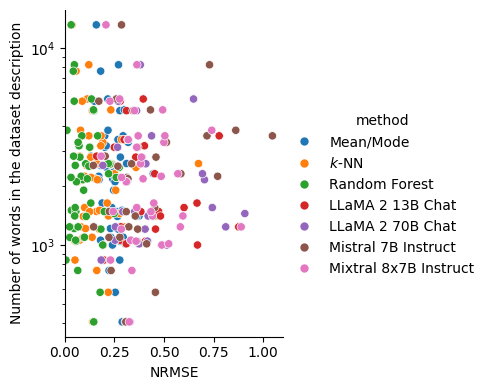

In [1020]:
g = sns.relplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', 
    height=4, aspect=0.9
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of words in the dataset description')
g.ax.set_yscale('log')
g.ax.set_xlim(0.0, 1.1)
g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-all.pdf', bbox_inches='tight')

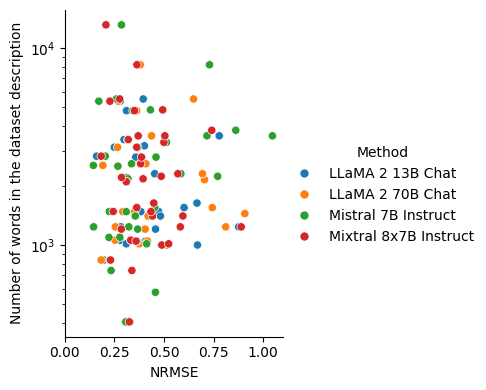

In [1021]:
g = sns.relplot(
    data=llm_rmse_df, x='rmse', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/nrmse-desclength-llm.pdf', bbox_inches='tight')

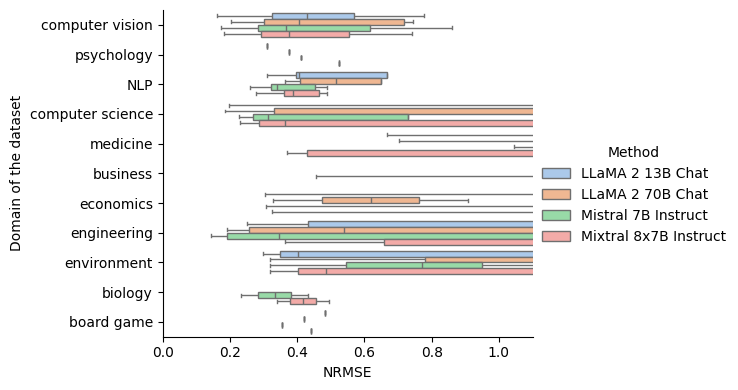

In [1022]:
g = sns.catplot(
  data=llm_rmse_df, x="rmse", y="category", hue="method", palette='pastel',
  kind="box", height=4, aspect=1.5,
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/nrmse-domain-llm.pdf', bbox_inches='tight')

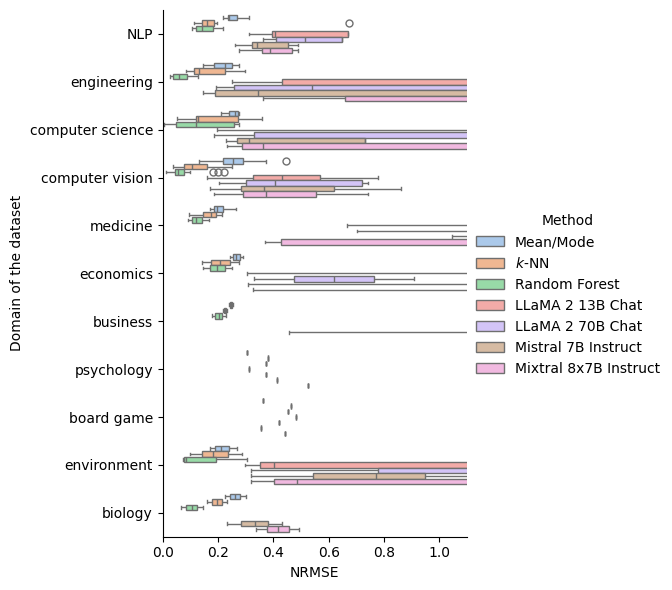

In [1023]:
g = sns.catplot(
  data=rmse_df, x="rmse", y="category", hue="method", palette='pastel',
  kind="box", height=6, aspect=0.9
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('NRMSE')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/nrmse-domain-all.pdf', bbox_inches='tight')

## $F_1$ score

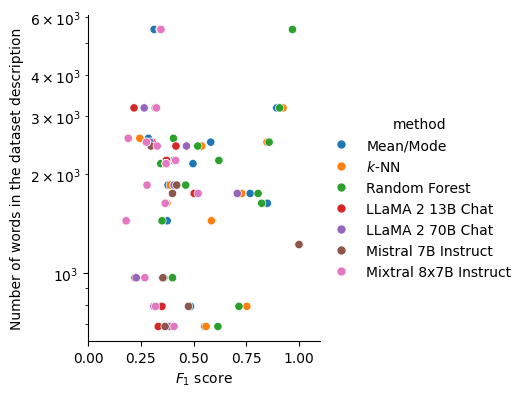

In [1024]:
g = sns.relplot(
    data=macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of words in the dataset description')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/f1-desclength-all.pdf', bbox_inches='tight')

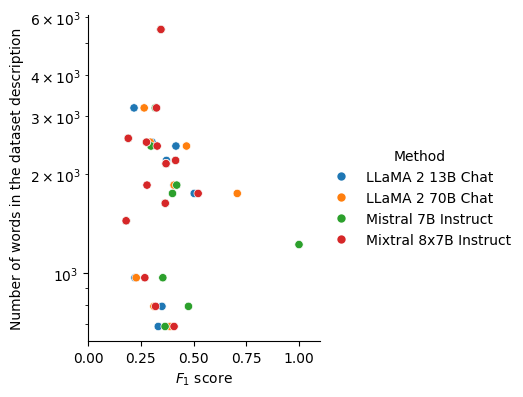

In [1025]:
g = sns.relplot(
    data=llm_macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.set_xlim(0, 1.1)
g.fig.savefig(output_dirpath / 'fig/f1-desclength-llm.pdf', bbox_inches='tight')

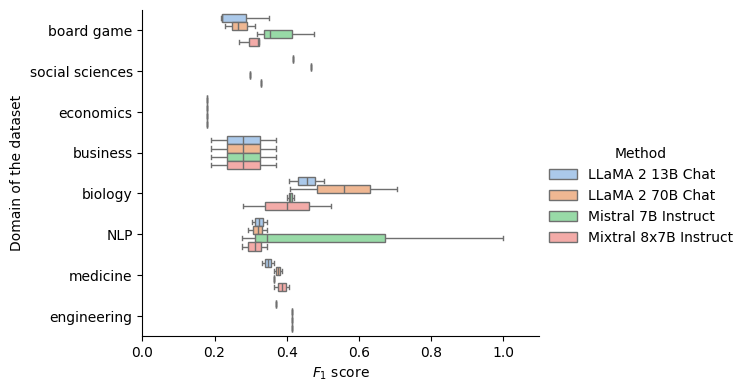

In [1026]:
g = sns.catplot(
  data=llm_macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel',
  kind="box", height=4, aspect=1.5,
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/f1-domain-llm.pdf', bbox_inches='tight')

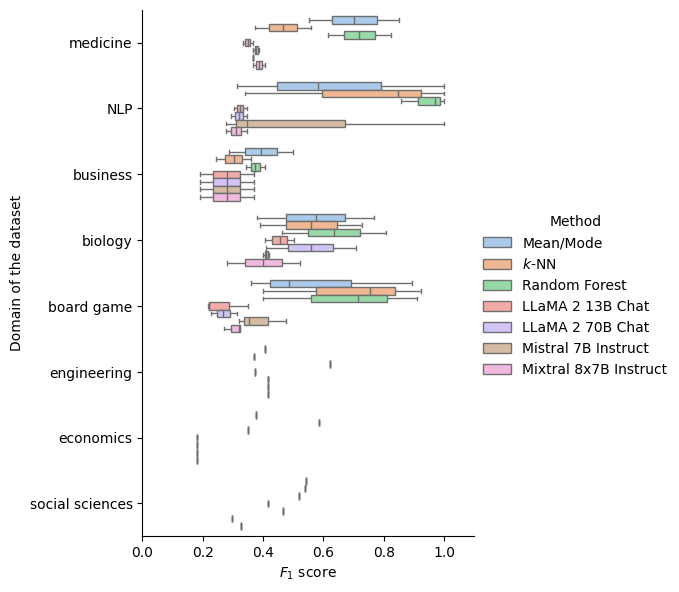

In [1027]:
g = sns.catplot(
  data=macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel',
  kind="box", height=6, aspect=0.9
)
g.ax.set_xlim(0, 1.1)
g.ax.set_xlabel('$F_1$ score')
g.ax.set_ylabel('Domain of the dataset')
g.legend.set_title('Method')
g.fig.savefig(output_dirpath / 'fig/f1-domain-all.pdf', bbox_inches='tight')

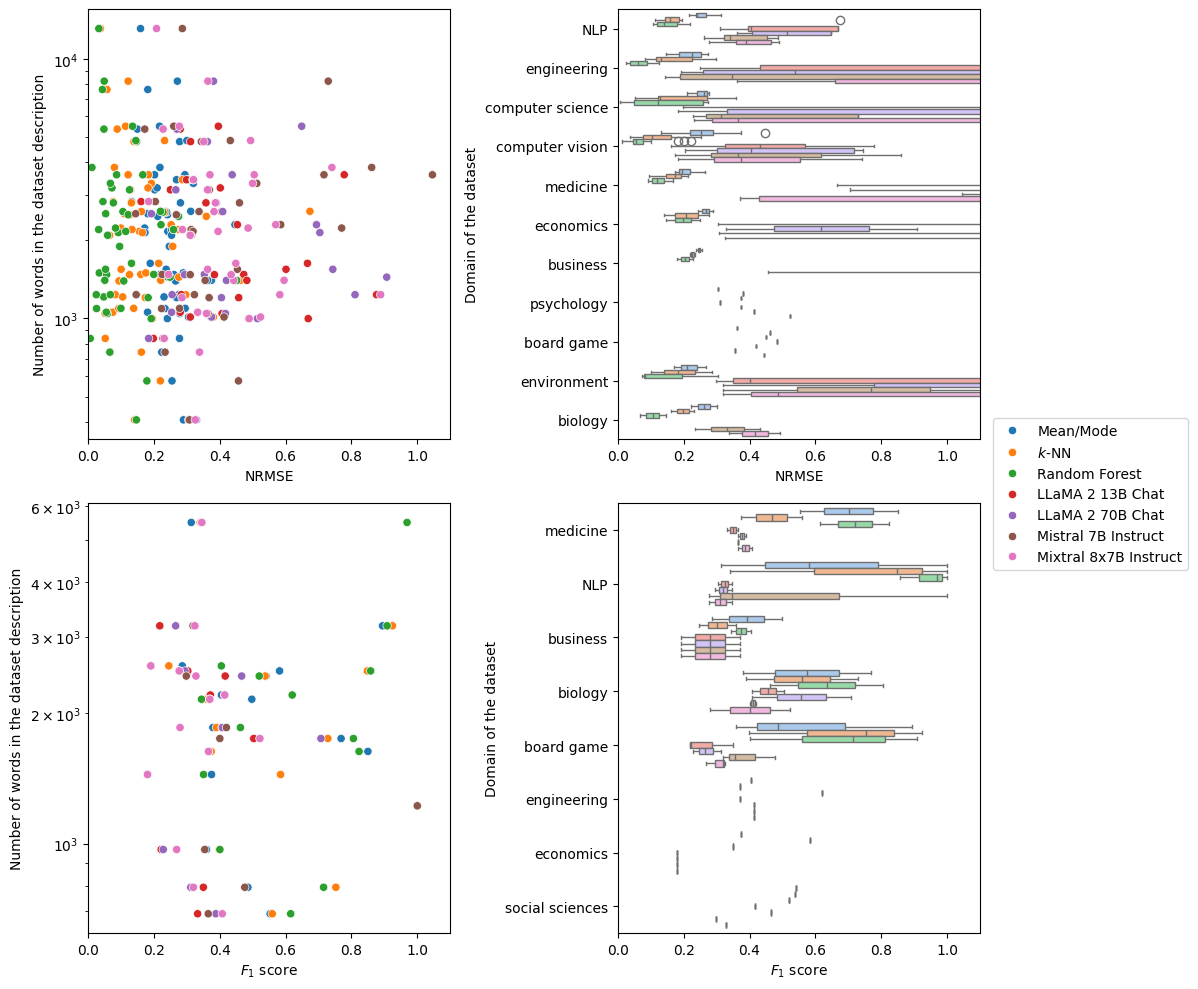

In [1028]:
import matplotlib.pyplot as plt
import seaborn as sns

# データをロードする
# ここで、rmse_dfとmacro_f1_dfデータフレームをロードしてください

# サブプロットを作成する
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # サイズは必要に応じて調整

# 1つ目のグラフ
sns.scatterplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', ax=axs[0, 0]
)
axs[0, 0].set_xlabel('NRMSE')
axs[0, 0].set_ylabel('Number of words in the dataset description')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(0.0, 1.1)

# 2つ目のグラフ
sns.boxplot(
    data=rmse_df, x="rmse", y="category", hue="method", palette='pastel', ax=axs[0, 1]
)
axs[0, 1].set_xlim(0, 1.1)
axs[0, 1].set_xlabel('NRMSE')
axs[0, 1].set_ylabel('Domain of the dataset')

# 3つ目のグラフ
sns.scatterplot(
    data=macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', ax=axs[1, 0]
)
axs[1, 0].set_xlabel('$F_1$ score')
axs[1, 0].set_ylabel('Number of words in the dataset description')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlim(0, 1.1)

# 4つ目のグラフ
sns.boxplot(
    data=macro_f1_df, x="macro_f1", y="category", hue="method", palette='pastel', ax=axs[1, 1]
)
axs[1, 1].set_xlim(0, 1.1)
axs[1, 1].set_xlabel('$F_1$ score')
axs[1, 1].set_ylabel('Domain of the dataset')

# 凡例を統一する
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))

# 各サブプロットの凡例を非表示にする
for ax in axs.flat:
    ax.legend().set_visible(False)

plt.tight_layout()
plt.show()


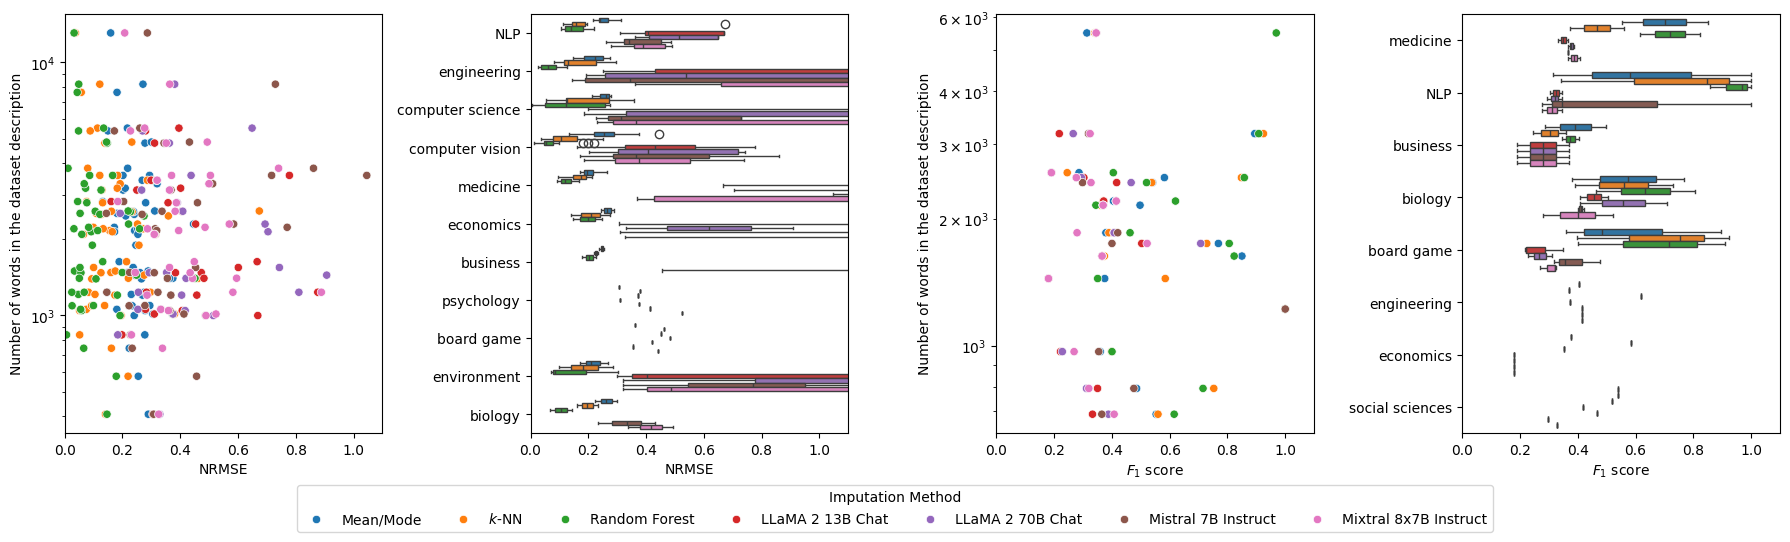

In [1049]:
import matplotlib.pyplot as plt
import seaborn as sns

# データをロードする
# ここで、rmse_dfとmacro_f1_dfデータフレームをロードしてください

# サブプロットを作成する
fig, axs = plt.subplots(1, 4, figsize=(18, 5))  # サイズは必要に応じて調整


sns.scatterplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', ax=axs[0]
)
axs[0].set_xlabel('NRMSE')
axs[0].set_ylabel('Number of words in the dataset description')
axs[0].set_yscale('log')
axs[0].set_xlim(0, 1.1)


sns.boxplot(
    data=rmse_df, x="rmse", y="category", hue="method", ax=axs[1]
)
axs[1].set_xlim(0, 1.1)
axs[1].set_xlabel('NRMSE')
axs[1].set_ylabel('')


sns.scatterplot(
    data=macro_f1_df, x='macro_f1', y='openml_desc_len', hue='method', ax=axs[2]
)
axs[2].set_xlabel('$F_1$ score')
axs[2].set_ylabel('Number of words in the dataset description')
axs[2].set_yscale('log')
axs[2].set_xlim(0, 1.1)


sns.boxplot(
    data=macro_f1_df, x="macro_f1", y="category", hue="method", ax=axs[3]
)
axs[3].set_xlim(0, 1.1)
axs[3].set_xlabel('$F_1$ score')
axs[3].set_ylabel('')


# 凡例を統一する
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.09), ncol=7, title='Imputation Method')

# 各サブプロットの凡例を非表示にする
for ax in axs.flat:
    ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig(output_dirpath / 'fig/imputation-performance.pdf', bbox_inches='tight')
plt.show()

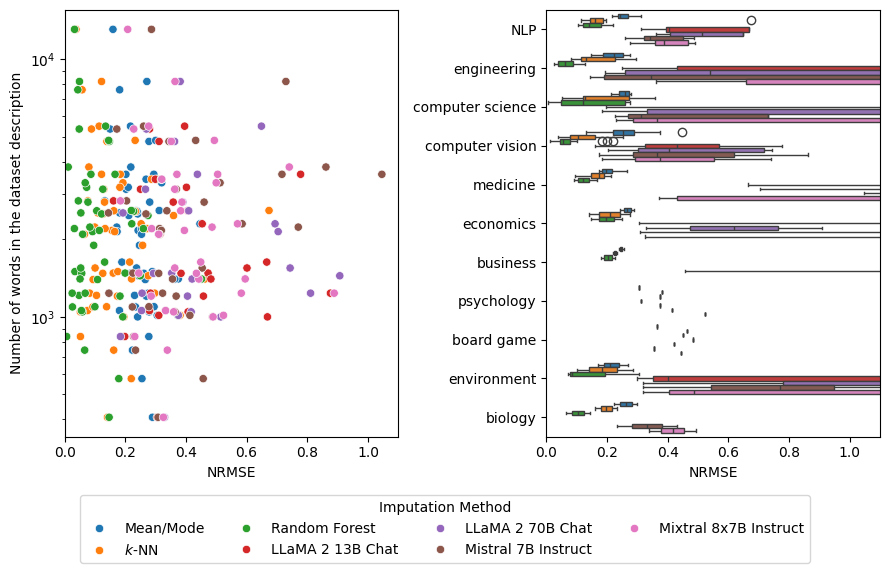

In [1050]:
import matplotlib.pyplot as plt
import seaborn as sns

# データをロードする
# ここで、rmse_dfとmacro_f1_dfデータフレームをロードしてください

# サブプロットを作成する
fig, axs = plt.subplots(1, 2, figsize=(9, 5))  # サイズは必要に応じて調整

# 1つ目のグラフ
sns.scatterplot(
    data=rmse_df, x='rmse', y='openml_desc_len', hue='method', ax=axs[0]
)
axs[0].set_xlabel('NRMSE')
axs[0].set_ylabel('Number of words in the dataset description')
axs[0].set_yscale('log')
axs[0].set_xlim(0.0, 1.1)

# 2つ目のグラフ
sns.boxplot(
    data=rmse_df, x="rmse", y="category", hue="method", ax=axs[1]
)
axs[1].set_xlim(0, 1.1)
axs[1].set_xlabel('NRMSE')
axs[1].set_ylabel('')

# 凡例を統一する
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, title='Imputation Method')

# 各サブプロットの凡例を非表示にする
for ax in axs.flat:
    ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig(output_dirpath / 'fig/nrmse.pdf', bbox_inches='tight')
plt.show()

# Downstream

In [1031]:
# calculate
# accuracy(method)/(accuracy(best imputation)-accuracy(baseline))

In [1032]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1494,4844,biology,MAR,41.0,0.881517,0.869511,1.639344,1.779321
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...
414,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978355,0.298507,0.294928
415,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,51.0,0.603758,0.514964,-0.805369,0.008017
416,Mixtral 8x7B Instruct,6.0,1468,1960,NLP,MAR,856.0,0.921296,0.916150,-0.500000,-0.601627
417,Mixtral 8x7B Instruct,6.0,4134,742,biology,MAR,1776.0,0.808256,0.803652,-0.164474,-0.138643


In [1033]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1494,4844,biology,MAR,41.0,0.881517,0.869511,1.639344,1.779321
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...
414,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978355,0.298507,0.294928
415,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,51.0,0.603758,0.514964,-0.805369,0.008017
416,Mixtral 8x7B Instruct,6.0,1468,1960,NLP,MAR,856.0,0.921296,0.916150,-0.500000,-0.601627
417,Mixtral 8x7B Instruct,6.0,4134,742,biology,MAR,1776.0,0.808256,0.803652,-0.164474,-0.138643


In [1034]:
downstream_df_desclen_summary = downstream_df.drop(['openml_id', 'missingness', 'category'], axis=1)
downstream_df_desclen_summary = downstream_df_desclen_summary.groupby(['method', 'openml_desc_len']).mean().reset_index()
downstream_df_desclen_summary = downstream_df_desclen_summary.sort_values('method_id').reset_index(drop=True)
downstream_df_desclen_summary

,method,openml_desc_len,method_id,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,2501,0.0,30.0,0.967888,0.967218,0.000000,0.000000
1,Mean/Mode,1960,0.0,856.0,0.925926,0.920760,0.000000,-0.101402
2,Mean/Mode,1895,0.0,27.0,0.771208,0.764473,-0.662252,0.545108
3,Mean/Mode,1852,0.0,60.0,0.967085,0.963788,0.652529,0.754800
4,Mean/Mode,1747,0.0,180.0,0.960815,0.957305,0.000000,0.016809
...,...,...,...,...,...,...,...,...
407,Mixtral 8x7B Instruct,2434,6.0,9.0,0.508475,0.474868,-3.846154,-3.739191
408,Mixtral 8x7B Instruct,2297,6.0,256.0,0.937304,0.936006,2.047782,2.104229
409,Mixtral 8x7B Instruct,2230,6.0,5.0,0.971074,0.833333,0.000000,0.444963
410,Mixtral 8x7B Instruct,3130,6.0,24.0,0.991758,0.987753,0.092421,0.113531


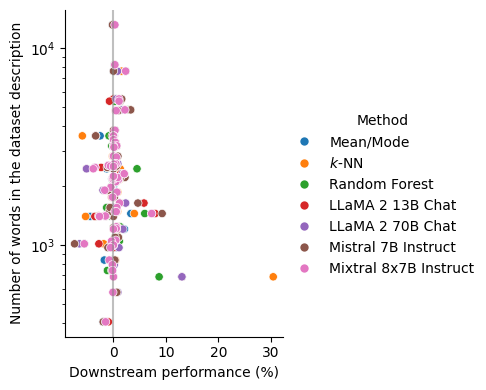

In [1035]:
g = sns.relplot(
    data=downstream_df_desclen_summary, x='effect_accuracy', y='openml_desc_len', hue='method', height=4, aspect=0.9,
)
g.ax.set_xlabel('Downstream performance (%)')
g.ax.set_ylabel('Number of words in the dataset description')
g.legend.set_title('Method')
g.ax.set_yscale('log')
g.ax.axvline(x=0, color='gray', alpha=0.5)

In [1036]:
downstream_df_domain_summary = downstream_df.drop(['openml_id', 'openml_desc_len', 'missingness'], axis=1)
downstream_df_domain_summary = downstream_df_domain_summary.groupby(['method', 'category']).mean().reset_index()
downstream_df_domain_summary = downstream_df_domain_summary.sort_values('method_id').reset_index(drop=True)

Text(94.42649652777779, 0.5, 'Domain of the dataset')

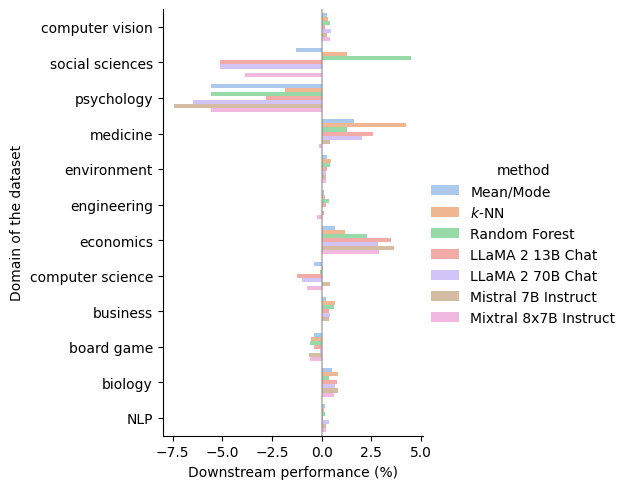

In [1037]:
g = sns.catplot(
    data=downstream_df_domain_summary, x="effect_accuracy", y="category", hue="method", palette='pastel',
    kind="bar"
)
g.ax.axvline(x=0, color='gray', alpha=0.5)
g.ax.set_xlabel('Downstream performance (%)')
g.ax.set_ylabel('Domain of the dataset')

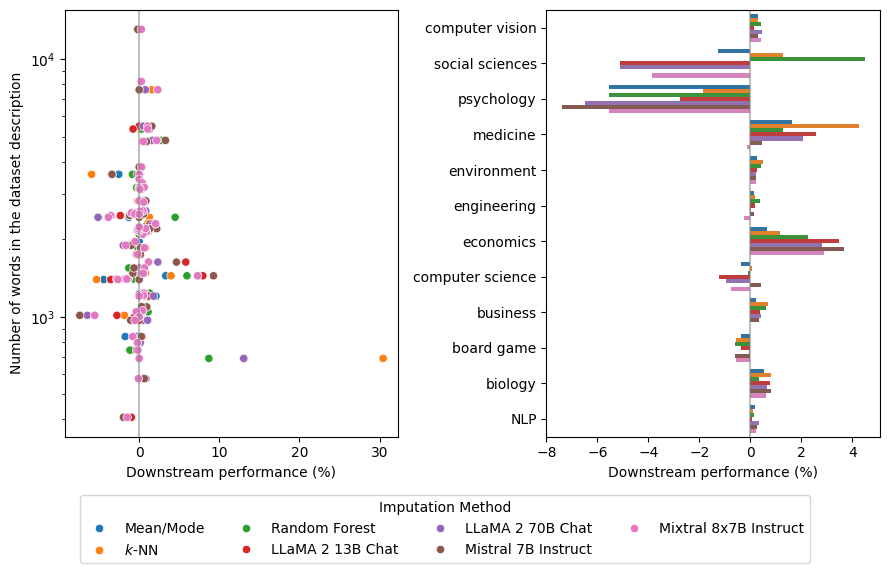

In [1051]:
fig, axs = plt.subplots(1, 2, figsize=(9, 5))  # サイズは必要に応じて調整

sns.scatterplot(
    data=downstream_df_desclen_summary, x='effect_accuracy', y='openml_desc_len', hue='method', ax=axs[0]
)
axs[0].set_xlabel('Downstream performance (%)')
axs[0].set_ylabel('Number of words in the dataset description')
axs[0].set_yscale('log')
axs[0].axvline(x=0, color='gray', alpha=0.5)

# 4つ目のグラフ
sns.barplot(
    data=downstream_df_domain_summary, x="effect_accuracy", y="category", hue="method", ax=axs[1]
)
axs[1].set_xlabel('Downstream performance (%)')
axs[1].set_ylabel('')
axs[1].axvline(x=0, color='gray', alpha=0.5)

# 凡例を統一する
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, title='Imputation Method')

# 各サブプロットの凡例を非表示にする
for ax in axs.flat:
    ax.legend().set_visible(False)
    
plt.tight_layout()
plt.savefig(output_dirpath / 'fig/downstream.pdf', bbox_inches='tight')
plt.show()

In [1039]:
downstream_df

,method,method_id,openml_id,openml_desc_len,category,missingness,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,1494,4844,biology,MAR,41.0,0.881517,0.869511,1.639344,1.779321
1,Mean/Mode,0.0,1068,2532,engineering,MAR,21.0,0.914414,0.564391,-0.975610,-1.869504
2,Mean/Mode,0.0,1067,2509,computer science,MAR,21.0,0.857820,0.647393,-0.275482,0.602676
3,Mean/Mode,0.0,1063,2473,computer science,MAR,21.0,0.800000,0.669366,-1.176471,-1.375691
4,Mean/Mode,0.0,1050,1235,engineering,MAR,37.0,0.894569,0.569356,1.083032,14.858135
...,...,...,...,...,...,...,...,...,...,...,...
414,Mixtral 8x7B Instruct,6.0,1478,3817,computer vision,MAR,561.0,0.978641,0.978355,0.298507,0.294928
415,Mixtral 8x7B Instruct,6.0,1475,838,computer science,MAR,51.0,0.603758,0.514964,-0.805369,0.008017
416,Mixtral 8x7B Instruct,6.0,1468,1960,NLP,MAR,856.0,0.921296,0.916150,-0.500000,-0.601627
417,Mixtral 8x7B Instruct,6.0,4134,742,biology,MAR,1776.0,0.808256,0.803652,-0.164474,-0.138643


In [1040]:
downstream_df_summarized = downstream_df.drop(['openml_id', 'openml_desc_len', 'missingness', 'category'], axis=1)
downstream_df_summarized = downstream_df_summarized.groupby(['method']).mean().reset_index()
downstream_df_summarized = downstream_df_summarized.sort_values('method_id').reset_index(drop=True)

In [1041]:
downstream_df_summarized

,method,method_id,n_features,accuracy,macro_f1,effect_accuracy,effect_macro_f1
0,Mean/Mode,0.0,216.53125,0.863099,0.806426,0.177527,0.901315
1,$k$-NN,1.0,216.53125,0.864354,0.808092,0.567853,1.352539
2,Random Forest,2.0,216.53125,0.864720,0.809029,0.367544,1.265953
3,LLaMA 2 13B Chat,3.0,42.156863,0.863319,0.794066,0.285818,1.295117
4,LLaMA 2 70B Chat,4.0,43.132075,0.863203,0.795878,0.250699,1.204003
5,Mistral 7B Instruct,5.0,171.206349,0.871091,0.813155,0.241821,0.943762
6,Mixtral 8x7B Instruct,6.0,123.666667,0.867053,0.806779,0.014484,0.726892
